In [197]:
#!pip install xgboost

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

In [4]:
HOME = Path().resolve().parent.parent
data_dir = str(HOME) + '/data/processed/'

In [3]:
listings = pd.read_csv(data_dir + 'listings_transformed.csv.gz')
listings.shape

(456987, 24)

### 1. Preparing the dataset to make predictions

In [30]:
useful_features = ['id', 'year', 'month', 'beds', 'bedrooms', 'number_of_reviews', 'amenities', 'room_type',
                   'bathrooms', 'price', 'reviews_per_month', 'accommodates', 'review_scores_rating', 
                  'neighbourhood_group_cleansed', 'is_high_season', 'availability_30', 'availability_60']

In [31]:
df = listings[useful_features].groupby(['year', 'month', 'id'], as_index=False).mean()

timeline = df['year']*12 + df['month']
df.insert(2, 'monthly_timeline', timeline)

### 3. Preprocessing data

In [32]:
ids = df.id.unique()

df['av60_lag1'] = 0.0
df['av60_lag2'] = 0.0

for id in ids:
    df.loc[df.id == id, 'av60_lag1'] = df[df.id == id]['availability_60'].shift(1)
    df.loc[df.id == id, 'av60_lag2'] = df[df.id == id]['availability_60'].shift(2)

In [33]:
df2 = df.dropna().copy()

In [49]:
df2.shape

(379767, 20)

### 2. Split train and test set

In [36]:
train = df2[df2['monthly_timeline'] <= 24255].copy()
test = df2[df2['monthly_timeline'] > 24255].copy()

In [39]:
X_train, y_train = train.drop('availability_60', axis=1), train['availability_60']
X_test, y_test = test.drop('availability_60', axis=1), test['availability_60']

### 3. Standardization and Normalization

In [40]:
transformer = RobustScaler()
X_train_norm = transformer.fit_transform(X_train)
X_test_norm = transformer.transform(X_test)

### 4. Train XGBoost model

In [41]:
xgb_model = xgb.XGBRegressor()

In [42]:
xgb_model.fit(X_train_norm, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 5. Predict and validate results

In [43]:
# Predict

train_pred = xgb_model.predict(X_train_norm)
test_pred = xgb_model.predict(X_test_norm)

In [44]:
# Compute RMSE

train_rmse = mean_squared_error(y_train, train_pred)
test_rmse = mean_squared_error(y_test, test_pred)

In [48]:
print(f'The Train RMSE is {train_rmse:.2f}\nThe Test RMSE is {test_rmse:.2f}')

The Train RMSE is 43.49
The Test RMSE is 42.95


### 6. Variable importance for the model

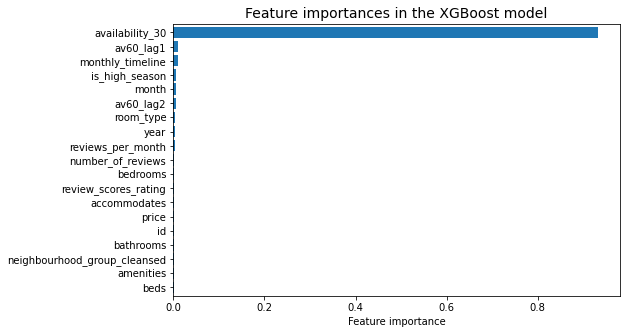

In [46]:
# Producing a dataframe of feature importances
features_weights = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
features_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,5))
plt.barh(features_weights.index, features_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()